# 🌊 Style Trajectory Analysis (Colab ver.)

## 슬라이딩 윈도우 + POS 시퀀스 + GRU 모델

**⚠️ 중요: 첫 번째 셀 실행 후 런타임을 재시작해주세요!**
- 메뉴: 런타임 → 런타임 다시 시작
- 그 후 두 번째 셀부터 실행

In [1]:
# ⚠️ [1단계] 이 셀 실행 후 반드시 '런타임 다시 시작' 하세요!
# 메뉴: 런타임 → 런타임 다시 시작 (또는 Ctrl+M .)

!pip install -q konlpy

print("")
print("="*60)
print("⚠️  지금 런타임을 재시작하세요!")
print("   메뉴: 런타임 → 런타임 다시 시작")
print("   또는 Ctrl+M 누른 후 . (마침표)")
print("="*60)
print("")
print("재시작 후 이 셀은 건너뛰고 다음 셀부터 실행하세요!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 36.6 MB/s eta 0:00:00

⚠️  지금 런타임을 재시작하세요!
   메뉴: 런타임 → 런타임 다시 시작
   또는 Ctrl+M 누른 후 . (마침표)

재시작 후 이 셀은 건너뛰고 다음 셀부터 실행하세요!


In [1]:
# [2단계] 런타임 재시작 후 여기부터 실행!

# 한글 폰트 설정
!apt-get install -qq fonts-nanum

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

print("✅ 폰트 설정 완료")

Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
✅ 폰트 설정 완료


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import re
from konlpy.tag import Okt
import warnings
warnings.filterwarnings('ignore')

# Okt 로드
okt = Okt()
print("✅ Okt 형태소 분석기 로드 완료")

✅ Okt 형태소 분석기 로드 완료


## 📊 데이터 로드

In [4]:
# 경로 설정 (본인 환경에 맞게 수정하세요)
DATA_PATH = '/content/drive/MyDrive/멋사_프로젝트_01/train.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ 데이터 로드 성공: {len(df):,}개")
except FileNotFoundError:
    print("❌ 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

✅ 데이터 로드 성공: 97,172개


In [5]:
# 샘플 추출
ai_samples = df[df['generated'] == 1].sample(50, random_state=42)
human_samples = df[df['generated'] == 0].sample(50, random_state=42)

print(f"샘플: AI {len(ai_samples)}, Human {len(human_samples)}")

샘플: AI 50, Human 50


## 🛠️ Feature 추출 (Okt 사용)

In [6]:
def split_sentences(text):
    """문장 분할 (정규식)"""
    sentences = re.split(r'[.!?]+', str(text))
    return [s.strip() for s in sentences if s.strip()]

def extract_pos_features(text):
    """Okt 기반 POS 분석"""
    try:
        pos_tags = okt.pos(text, norm=True, stem=True)
        total = max(len(pos_tags), 1)

        counts = Counter([tag for word, tag in pos_tags])

        return {
            'noun_ratio': counts.get('Noun', 0) / total,
            'verb_ratio': counts.get('Verb', 0) / total,
            'adj_ratio': counts.get('Adjective', 0) / total,
            'josa_ratio': counts.get('Josa', 0) / total,
            'eomi_ratio': counts.get('Eomi', 0) / total,
            'adverb_ratio': counts.get('Adverb', 0) / total,
        }
    except Exception as e:
        return {
            'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
            'josa_ratio': 0, 'eomi_ratio': 0, 'adverb_ratio': 0
        }

def extract_window_features(text):
    """한 윈도우에서 모든 Feature 추출"""
    sentences = split_sentences(text)
    if not sentences:
        return [0] * 11

    words = text.split()

    # 1. 문장 길이
    sent_lengths = [len(s) for s in sentences]
    avg_sent_len = np.mean(sent_lengths)
    std_sent_len = np.std(sent_lengths) if len(sent_lengths) > 1 else 0

    # 2. 어휘 다양성 (TTR)
    ttr = len(set(words)) / max(len(words), 1)

    # 3. 쉼표 밀도
    comma_density = text.count(',') / max(len(sentences), 1)

    # 4. 반복률
    word_counts = Counter(words)
    repeated = sum(1 for w, c in word_counts.items() if c >= 2)
    repetition = repeated / max(len(word_counts), 1)

    # 5. POS
    pos = extract_pos_features(text)

    return [
        avg_sent_len, std_sent_len, ttr, comma_density, repetition,
        pos['noun_ratio'], pos['verb_ratio'], pos['adj_ratio'],
        pos['josa_ratio'], pos['eomi_ratio'], pos['adverb_ratio']
    ]

FEATURE_NAMES = [
    'avg_sent_len', 'std_sent_len', 'ttr', 'comma_density', 'repetition',
    'noun', 'verb', 'adj', 'josa', 'eomi', 'adverb'
]

print("✅ Feature 함수 정의 완료")

✅ Feature 함수 정의 완료


## 🌊 시퀀스 추출 (글자 수 기반)

In [18]:
def extract_feature_sequence(text, window_size=100, stride=200):
    """글자 수 기반 슬라이딩 윈도우"""
    text = str(text)

    if len(text) < window_size:
        return np.array([extract_window_features(text)])

    sequences = []
    for i in range(0, len(text) - window_size + 1, stride):
        window_text = text[i:i + window_size]
        features = extract_window_features(window_text)
        sequences.append(features)

    return np.array(sequences)

print("✅ 글자 수 기반 시퀀스 추출 함수 정의 완료")

✅ 글자 수 기반 시퀀스 추출 함수 정의 완료


## 📊 시각화 (길이 맞춤)

In [8]:
# 샘플 선택
sample_ai = ai_samples.iloc[0]['full_text']
sample_human = human_samples.iloc[0]['full_text']

# 길이 맞추기 (짧은 쪽에 맞춤)
min_len = min(len(sample_ai), len(sample_human))
sample_ai_cut = sample_ai[:min_len]
sample_human_cut = sample_human[:min_len]

print(f"원본 AI: {len(sample_ai):,} 글자 → 자른 후: {len(sample_ai_cut):,} 글자")
print(f"원본 Human: {len(sample_human):,} 글자 → 자른 후: {len(sample_human_cut):,} 글자")

# 시퀀스 추출
seq_ai = extract_feature_sequence(sample_ai_cut)
seq_human = extract_feature_sequence(sample_human_cut)

print(f"\nAI 윈도우: {len(seq_ai)}, Human 윈도우: {len(seq_human)}")

원본 AI: 738 글자 → 자른 후: 738 글자
원본 Human: 4,490 글자 → 자른 후: 738 글자

AI 윈도우: 2, Human 윈도우: 2


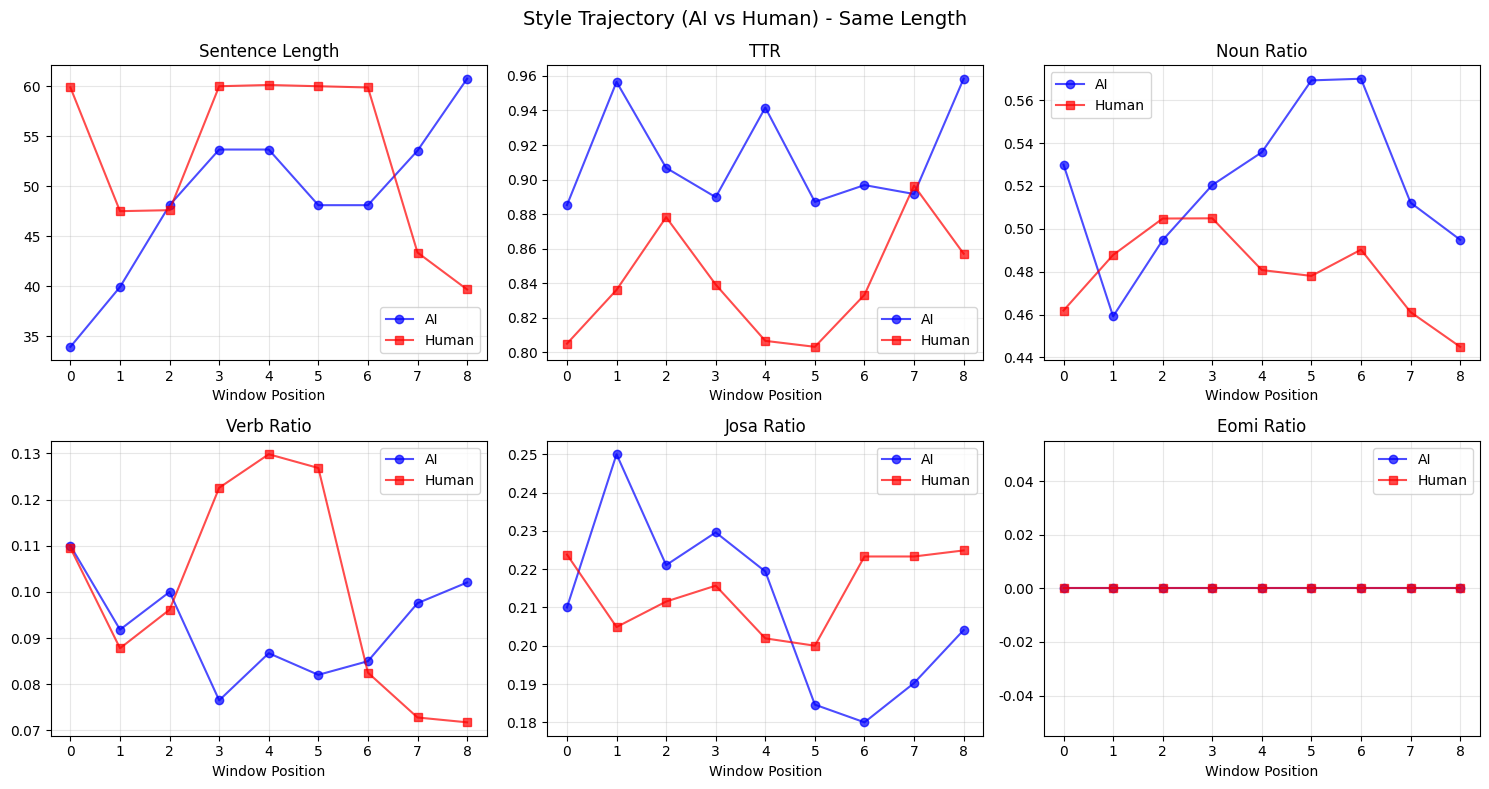

In [19]:
# 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
features_idx = [0, 2, 5, 6, 8, 9]  # 길이, TTR, 명사, 동사, 조사, 어미
titles = ['Sentence Length', 'TTR', 'Noun Ratio', 'Verb Ratio', 'Josa Ratio', 'Eomi Ratio']

for ax, f_idx, title in zip(axes.flatten(), features_idx, titles):
    ax.plot(seq_ai[:, f_idx], 'b-o', label='AI', alpha=0.7)
    ax.plot(seq_human[:, f_idx], 'r-s', label='Human', alpha=0.7)
    ax.set_xlabel('Window Position')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle('Style Trajectory (AI vs Human) - Same Length', fontsize=14)
plt.tight_layout()
plt.show()

## 🤖 1D CNN + GRU 모델 학습

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

class StyleSequenceDataset(Dataset):
    def __init__(self, texts, labels, max_len=50):
        self.data = []
        self.labels = []

        for t, l in tqdm(zip(texts, labels), total=len(texts), desc="Feature Extracting"):
            seq = extract_feature_sequence(t)

            if len(seq) > max_len:
                seq = seq[:max_len]
            else:
                pad = np.zeros((max_len - len(seq), seq.shape[1]))
                seq = np.vstack([seq, pad])

            self.data.append(torch.FloatTensor(seq))
            self.labels.append(torch.FloatTensor([l]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i], self.labels[i]

class HybridCNNGRU(nn.Module):
    def __init__(self, input_dim=11, hidden_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, 3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.gru = nn.GRU(64, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*2, 32), nn.ReLU(),
            nn.Linear(32, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        _, h = self.gru(x)
        h = torch.cat([h[-2], h[-1]], dim=1)
        return self.fc(h)

print("✅ 모델 클래스 정의 완료")

✅ 모델 클래스 정의 완료


In [21]:
# 학습 데이터 준비
texts = list(ai_samples['full_text']) + list(human_samples['full_text'])
labels = [1]*len(ai_samples) + [0]*len(human_samples)

dataset = StyleSequenceDataset(texts, labels)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HybridCNNGRU().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

print(f"Device: {device}")
print(f"학습 데이터: {len(dataset)}개")

Feature Extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Device: cuda
학습 데이터: 100개


In [27]:
# 학습 실행
print("🚀 학습 시작...")
history = []

for epoch in range(8):
    total_loss = 0
    correct = 0
    total = 0

    model.train()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += ((pred > 0.5) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    avg_loss = total_loss / len(loader)
    history.append({'epoch': epoch+1, 'loss': avg_loss, 'acc': acc})
    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f} | Acc: {acc:.4f}")

print("\n✅ 학습 완료!")

🚀 학습 시작...
Epoch  1 | Loss: 0.6152 | Acc: 0.7200
Epoch  2 | Loss: 0.6147 | Acc: 0.6900
Epoch  3 | Loss: 0.6195 | Acc: 0.6700
Epoch  4 | Loss: 0.7215 | Acc: 0.5300
Epoch  5 | Loss: 0.6779 | Acc: 0.5300
Epoch  6 | Loss: 0.6435 | Acc: 0.6400
Epoch  7 | Loss: 0.6390 | Acc: 0.7100
Epoch  8 | Loss: 0.6228 | Acc: 0.7100

✅ 학습 완료!


## 📊 학습 후 시각화

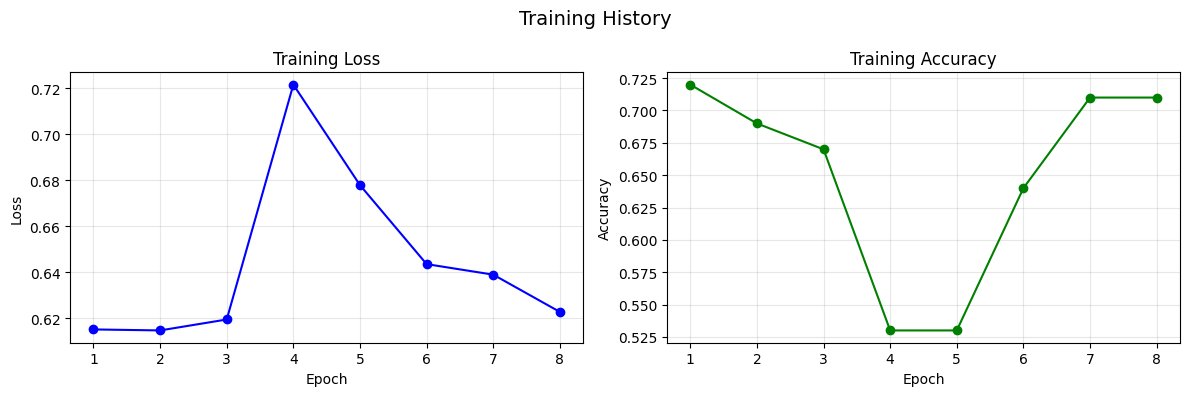

In [28]:
# 1. 학습 곡선
history_df = pd.DataFrame(history)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_df['epoch'], history_df['loss'], 'b-o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_df['epoch'], history_df['acc'], 'g-o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14)
plt.tight_layout()
plt.show()

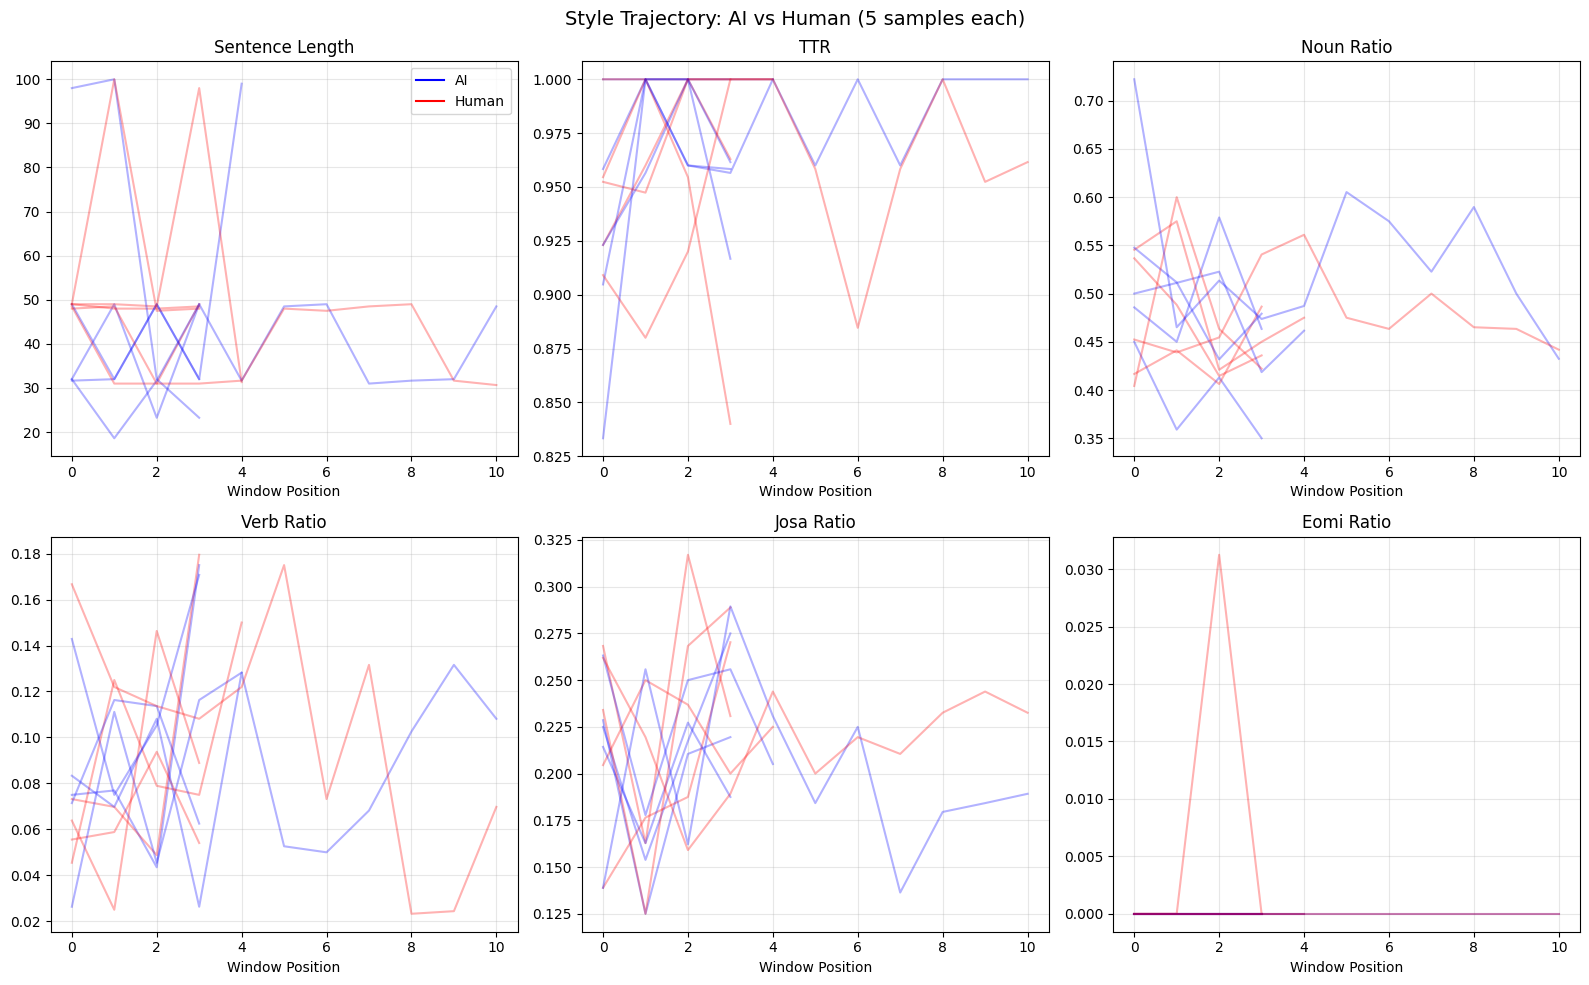

In [29]:
# 2. 여러 샘플 비교 (길이 맞춤)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
features_idx = [0, 2, 5, 6, 8, 9]
titles = ['Sentence Length', 'TTR', 'Noun Ratio', 'Verb Ratio', 'Josa Ratio', 'Eomi Ratio']

# AI 5개, Human 5개 샘플 비교
for i in range(5):
    ai_text = ai_samples.iloc[i]['full_text']
    human_text = human_samples.iloc[i]['full_text']

    # 길이 맞추기
    min_len = min(len(ai_text), len(human_text))
    ai_text_cut = ai_text[:min_len]
    human_text_cut = human_text[:min_len]

    seq_ai = extract_feature_sequence(ai_text_cut)
    seq_human = extract_feature_sequence(human_text_cut)

    for ax, f_idx in zip(axes.flatten(), features_idx):
        ax.plot(seq_ai[:, f_idx], 'b-', alpha=0.3)
        ax.plot(seq_human[:, f_idx], 'r-', alpha=0.3)

for ax, title in zip(axes.flatten(), titles):
    ax.set_title(title)
    ax.set_xlabel('Window Position')
    ax.grid(True, alpha=0.3)

# 범례
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', label='AI'),
                   Line2D([0], [0], color='r', label='Human')]
axes[0, 0].legend(handles=legend_elements)

plt.suptitle('Style Trajectory: AI vs Human (5 samples each)', fontsize=14)
plt.tight_layout()
plt.show()

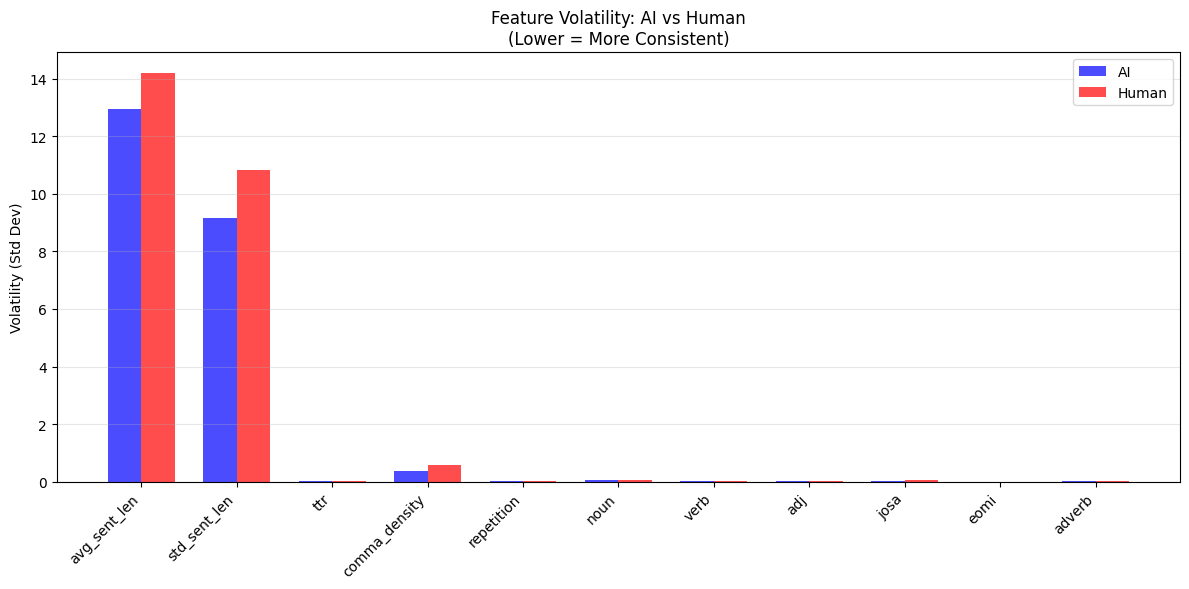

In [30]:
# 3. 변동성(Volatility) 비교 막대그래프
ai_vols = []
human_vols = []

for i in range(len(ai_samples)):
    seq = extract_feature_sequence(ai_samples.iloc[i]['full_text'])
    if len(seq) > 1:
        ai_vols.append(np.std(seq, axis=0))

for i in range(len(human_samples)):
    seq = extract_feature_sequence(human_samples.iloc[i]['full_text'])
    if len(seq) > 1:
        human_vols.append(np.std(seq, axis=0))

ai_vol_mean = np.mean(ai_vols, axis=0)
human_vol_mean = np.mean(human_vols, axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(FEATURE_NAMES))
width = 0.35

ax.bar(x - width/2, ai_vol_mean, width, label='AI', color='blue', alpha=0.7)
ax.bar(x + width/2, human_vol_mean, width, label='Human', color='red', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(FEATURE_NAMES, rotation=45, ha='right')
ax.set_ylabel('Volatility (Std Dev)')
ax.set_title('Feature Volatility: AI vs Human\n(Lower = More Consistent)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [31]:
# 4. 수치 출력
print("\n📊 Feature별 변동성 비교:")
print("="*60)
print(f"{'Feature':<15} {'AI':>12} {'Human':>12} {'Diff':>12}")
print("-"*60)
for i, name in enumerate(FEATURE_NAMES):
    diff = human_vol_mean[i] - ai_vol_mean[i]
    marker = "⬆️" if diff > 0 else "⬇️"
    print(f"{name:<15} {ai_vol_mean[i]:>12.4f} {human_vol_mean[i]:>12.4f} {diff:>+12.4f} {marker}")

# print("\n💡 해석:")
# print("  - AI: 변동성이 낮음 = 스타일이 일관됨 (기계적)")
# print("  - Human: 변동성이 높음 = 스타일이 변화함 (자연스러움)")


📊 Feature별 변동성 비교:
Feature                   AI        Human         Diff
------------------------------------------------------------
avg_sent_len         12.9493      14.2102      +1.2610 ⬆️
std_sent_len          9.1695      10.8412      +1.6717 ⬆️
ttr                   0.0352       0.0400      +0.0048 ⬆️
comma_density         0.3570       0.5712      +0.2142 ⬆️
repetition            0.0357       0.0403      +0.0046 ⬆️
noun                  0.0557       0.0512      -0.0045 ⬇️
verb                  0.0357       0.0379      +0.0022 ⬆️
adj                   0.0240       0.0250      +0.0010 ⬆️
josa                  0.0426       0.0441      +0.0015 ⬆️
eomi                  0.0008       0.0006      -0.0002 ⬇️
adverb                0.0093       0.0111      +0.0018 ⬆️
